In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, date, time, timedelta
import matplotlib.pyplot as plt
from scipy import stats,optimize
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import r2_score,mean_squared_error
from scipy.stats import jarque_bera,zscore

import requests
import json

/home/robin/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
raw_spiro = pd.read_csv('raw_spiro.csv',parse_dates=['Date'])
raw_spiro.set_index(['Date'],inplace=True)
raw_spiro = raw_spiro.drop(['Time'], axis=1)
raw_spiro.tail()

,PEF(l/min),FEV1(l),unixDate,unixTime,Hour
Date,,,,,
2020-04-11,346,2.37,18363.0,81480.0,22
2020-04-12,351,2.22,18364.0,42840.0,11
2020-04-12,508,3.09,18364.0,71520.0,19
2020-04-12,526,3.15,18364.0,79380.0,22
2020-04-13,495,3.03,18365.0,80100.0,22


In [4]:
#https://docs.airnowapi.org/
TOKEN = %env AIR_NOW_TOKEN

In [5]:
def get_daily_pollution(date,zip_code,factors,distance=5):
    r = requests.get('http://www.airnowapi.org/aq/observation/zipCode/historical/?format=application/json'
                     +'&zipCode=' + str(zip_code) + '&date=' + date.strftime('%Y-%m-%d') + 'T00-0000'
                     +'&distance=' + str(distance) + '&API_KEY=' + TOKEN)
    return json.loads(r.text)

In [ ]:
zip_code = 11432
distance = 5
factors = ['OZONE','PM2.5','PM10']
results = pd.DataFrame(columns=factors,index=raw_spiro.index)
for day in raw_spiro.index:
    daily_pollution = get_daily_pollution(day,zip_code,factors)
    df = pd.DataFrame(columns=factors)
    for item in daily_pollution:
        for factor in factors:
            if item['ParameterName'] == factor:
                results[factor][day] = item['AQI']
results.to_csv('pollution_airnow.csv')
results.head()

In [ ]:
inhaler_days = pd.read_csv('inhaler_days.csv')
inhaler_days = inhaler_days.rename(columns={'Unnamed: 0':'Date'})
inhaler_days = inhaler_days.set_index('Date')
inhaler_days = results.join(inhaler_days,how='inner').dropna()
inhaler_days = inhaler_days.drop_duplicates()
inhaler_days = inhaler_days.astype('float64')

In [66]:
inhaler_days['OZONE'] = list(map(lambda x: round(x,3),zscore(inhaler_days['OZONE'])))
inhaler_days['PM2.5'] = list(map(lambda x: round(x,3),zscore(inhaler_days['PM2.5'])))
inhaler_days['PM10'] = list(map(lambda x: round(x,3),zscore(inhaler_days['PM10'])))
print("PM10 mean :" ,inhaler_days['PM10'].mean())
print("PM2.5 mean :" ,inhaler_days['PM2.5'].mean())
print("OZONE mean :" ,inhaler_days['OZONE'].mean())

inhaler_days

PM10 mean : -4.761904761899215e-05
PM2.5 mean : -9.523809523801603e-05
OZONE mean : 4.7619047619042376e-05


,OZONE,PM2.5,PM10,first_reading,second_reading,difference
Date,,,,,,
2020-02-22,-0.070,1.009,0.980,388.0,415.0,27.0
2020-03-02,1.158,2.385,2.379,218.0,416.0,198.0
2020-03-03,-1.298,1.926,1.180,248.0,301.0,53.0
2020-03-04,-0.316,0.183,-0.619,218.0,274.0,56.0
2020-03-05,-1.052,-0.092,-0.419,317.0,439.0,122.0
2020-03-07,-0.070,-0.550,-1.218,280.0,441.0,161.0
2020-03-09,1.649,1.834,1.380,283.0,301.0,18.0
2020-03-12,-1.543,0.642,1.580,241.0,346.0,105.0
2020-03-13,0.421,-0.459,-0.019,333.0,388.0,55.0


In [67]:
spiro_pollution = results.join(raw_spiro,how='inner').dropna()
spiro_pollution.head()

,OZONE,PM2.5,PM10,PEF(l/min),FEV1(l),unixDate,unixTime,Hour
Date,,,,,,,,
2020-02-21,38,26,11,219,1.72,18313.0,36720.0,10
2020-02-21,38,26,11,253,1.78,18313.0,42300.0,11
2020-02-21,38,26,11,219,1.72,18313.0,36720.0,10
2020-02-21,38,26,11,253,1.78,18313.0,42300.0,11
2020-02-22,39,39,18,388,2.54,18314.0,12660.0,3


In [68]:
Y = spiro_pollution['PEF(l/min)']
X = spiro_pollution[['PM2.5','OZONE','PM10']].astype(float).fillna(0)
X = sm.add_constant(X)

mod = sm.OLS(Y,X)
fit = mod.fit()
summary = fit.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PEF(l/min)   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     14.88
Date:                Tue, 14 Apr 2020   Prob (F-statistic):           1.44e-09
Time:                        10:58:08   Log-Likelihood:                -10708.
No. Observations:                1820   AIC:                         2.142e+04
Df Residuals:                    1816   BIC:                         2.145e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        343.8041     23.902     14.384      0.000     296.926     390.682
PM2.5         -2.4018      0.416     -5.772      0.000      -3.218      -1.586
OZONE          1.7296      0.582      2.973      0.003       0.588       2.871
PM10           4.3047      0.839      5.133      0.000       2.660       5.949
==============================================================================
Omnibus:                       25.450   Durbin-Watson:                   1.491
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.784
Skew:                           0.205   Prob(JB):                     1.86e-05
Kurtosis:                       2.654   Cond. No.                         552.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
def lin_reg_plot(X,Y):
    regr = linear_model.LinearRegression()
    X = X.values.reshape(-1, 1)
    Y = Y.values.reshape(-1, 1)
    regr.fit(X, Y)
    Y_pred = regr.predict(X)    
    # Plot outputs
    plt.figure(figsize=(8, 8))
    plt.plot(X, Y_pred, color='red')
    plt.scatter(X, Y)
    plt.show()
    print('Coefficient: \n', round(regr.coef_[0][0],2))
    print('R-squared: %.2f'
          % r2_score(Y, Y_pred))

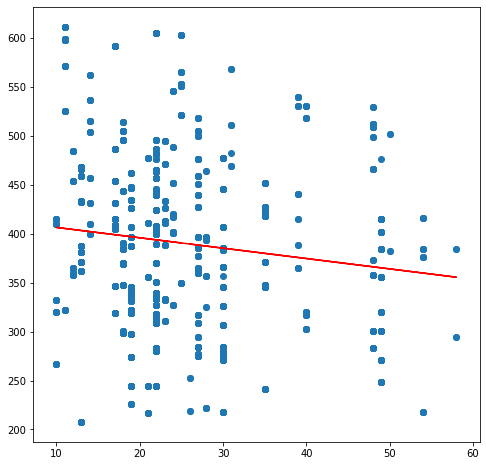

Coefficient: 
 -1.06
R-squared: 0.02


In [19]:
lin_reg_plot(spiro_pollution['PM2.5'],spiro_pollution['PEF(l/min)'])

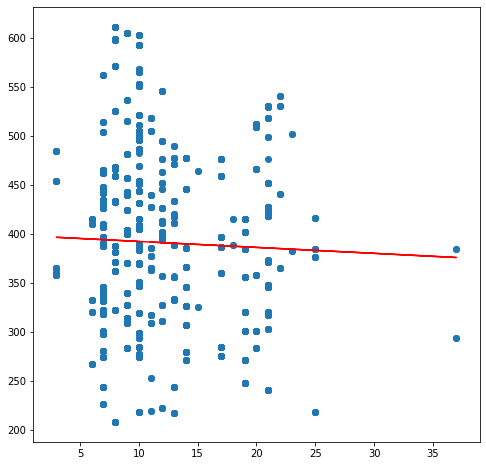

Coefficient: 
 -0.61
R-squared: 0.00


In [20]:
lin_reg_plot(spiro_pollution['PM10'],spiro_pollution['PEF(l/min)'])

In [9]:
pollution = pd.read_csv('pollution.csv',parse_dates=['date'])
pollution = pollution.rename(columns={"date": "Date"})
pollution.set_index('Date',inplace=True)
pollution = pollution.replace(' ','0')
pollution = pollution.astype('int64')

In [24]:
inhaler_days = pd.read_csv('inhaler_days.csv')
inhaler_days = inhaler_days.rename(columns={'Unnamed: 0':'Date'})
inhaler_days = inhaler_days.set_index('Date')
inhaler_days.head()

,first_reading,second_reading,difference
Date,,,
2020-02-22,388,415,27
2020-03-02,218,416,198
2020-03-03,248,301,53
2020-03-04,218,274,56
2020-03-05,317,439,122


In [ ]:
inhaler_days = pd.read_csv('inhaler_days.csv',parse_dates=['Unnamed: 0'])
raw_spiro.set_index(['Date'],inplace=True)
raw_spiro = raw_spiro.drop(['Time'], axis=1)
raw_spiro.head()

In [10]:
spiro_pollution = pollution.join(raw_spiro,how='inner')
spiro_pollution.head()

,pm25,o3,no2,co,PEF(l/min),FEV1(l),unixDate,unixTime,Hour
Date,,,,,,,,,
2020-02-21,15,27,12,2,219,1.72,18313.0,36720.0,10
2020-02-21,15,27,12,2,253,1.78,18313.0,42300.0,11
2020-02-22,16,26,22,3,388,2.54,18314.0,12660.0,3
2020-02-22,16,26,22,3,415,2.89,18314.0,480.0,0
2020-02-23,36,29,0,0,476,2.78,18315.0,70320.0,19


In [11]:
Y = spiro_pollution['PEF(l/min)']
X = spiro_pollution[[' pm25',' o3',' no2',' co']]
X = sm.add_constant(X)

mod = sm.OLS(Y,X)
fit = mod.fit()
summary = fit.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PEF(l/min)   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     2.862
Date:                Wed, 08 Apr 2020   Prob (F-statistic):             0.0242
Time:                        05:31:08   Log-Likelihood:                -1378.6
No. Observations:                 235   AIC:                             2767.
Df Residuals:                     230   BIC:                             2785.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        418.8710     69.636      6.015      0.000     281.665     556.077
 pm25          0.0642      0.542      0.118      0.906      -1.004       1.132
 o3            0.5872      2.017      0.291      0.771      -3.388       4.562
 no2           4.4702      2.094      2.135      0.034       0.345       8.595
 co          -51.1645     17.442     -2.933      0.004     -85.532     -16.797
==============================================================================
Omnibus:                        3.018   Durbin-Watson:                   1.649
Prob(Omnibus):                  0.221   Jarque-Bera (JB):                2.307
Skew:                           0.091   Prob(JB):                        0.316
Kurtosis:                       2.550   Cond. No.                         473.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
lin_reg_plot(spiro_pollution[' no2'],spiro_pollution['PEF(l/min)'])

NameError: name 'lin_reg_plot' is not defined